### Marine Lebrec <br> Last updated: April 15 2024

#### The goal of this notebook is to generate a Darwin Core Archive for a "Northern Calfironia Bull Kelp Forest Ecosystem Monitoring (1971-2019)" database

**Raw data access:** The latest publicly available version of this dataset is available on [DataONE](https://search.dataone.org/view/urn%3Auuid%3A41177927-92dc-421a-b8eb-d28f71537d96). Newer data files were sent to me by Bob Klamt and may be different from the DataONE archive. The latest files are those in the Research Workspace and used in this notebook.<br>

**Dataset description:** In this long-term, bull kelp forest monitoring program, divers quantify key marine invertebrates, algal cover and substrate types along transects inside and outside fished sites centered in Sonoma and Mendocino Counties, in northern California. Surveys are conducted to monitor the health of the kelp forest community focusing on important foundation species such as bull kelp, Nereocystis luetkeana, ecosystem engineers including purple sea urchins, Strongylocentrotus purpuratus, and fished species such as red abalone, Haliotis rufescens and red sea urchins, Mesocentrotus franciscanus. 

**Data tables**: 
- N_Coast_KelpForestSurveys_ObservedSpecies_SIZES_v3_20240130.csv: A size table, containing transect information, species ID, and the size of the species that was observed
- N_Coast_KelpForestSurveys_HABITAT_v2_20240222.csv: Algal habitat percent cover data 
- N_Coast_KelpForestSurveys_ObservedSpecies_COUNTS_v3_20240130.csv: : A count table, containing counts of different species observed along a transect<br>
- N_Coast_KelpForestSurveys_SUBSTRATE_v6_20240408: % cover of substrate (reef vs boulder vs cobble vs sand)

**Reference tables**:
- N_Coast_KelpForestSurveys_LOCATIONS_v4_20240105.csv: A site table, containing site codes and corresponding coordinates, as well as their protection status (MPA vs non-MPA)
- N_Coast_KelpForestSurveys_ObservedSpecies_CODES_v2_20240119: A species table, containing species IDs and their corresponding WoRMS Scientific Names. 
- N_Coast_KelpForestSurveys_SUBSTRATE_CODES_v1_240122.csv: A table containing substrate IDs and their corresponding substrate type, substrate description.
- N_Coast_KelpForestSurveys_ALGAL_HABITAT_CODES_v1_240122.csv: A table containing algal habitat IDs and their corresponding habitat type, habitat description.

In [441]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyworms
from datetime import date

In [442]:
# List tables to be used for DwC conversion
os.listdir('clean_data/')

['N_Coast_KelpForestSurveys_HABITAT_v3_20240408.csv',
 'N_Coast_KelpForestSurveys_ALGAL_HABITAT_CODES_v1_240122.csv',
 'N_Coast_KelpForestSurveys_ObservedSpecies_SIZES_v3_20240130.csv',
 'N_Coast_KelpForestSurveys_SUBSTRATE_v6_20240408.csv',
 'N_Coast_KelpForestSurveys_ObservedSpecies_COUNTS_v4_20240202.csv',
 'N_Coast_KelpForestSurveys_LOCATIONS_v4_20240105.csv',
 'N_Coast_KelpForestSurveys_SUBSTRATE_CODES_v1_240122.csv',
 'N_Coast_KelpForestSurveys_ObservedSpecies_CODES_v2_20240119.csv',
 'N_Coast_KelpForestSurveys_HABITAT_v3_20240408.csv',
 'N_Coast_KelpForestSurveys_ALGAL_HABITAT_CODES_v1_240122.csv',
 'N_Coast_KelpForestSurveys_ObservedSpecies_SIZES_v3_20240130.csv',
 'N_Coast_KelpForestSurveys_SUBSTRATE_v6_20240408.csv',
 'N_Coast_KelpForestSurveys_ObservedSpecies_COUNTS_v4_20240202.csv',
 'N_Coast_KelpForestSurveys_LOCATIONS_v4_20240105.csv',
 'N_Coast_KelpForestSurveys_SUBSTRATE_CODES_v1_240122.csv',
 'N_Coast_KelpForestSurveys_ObservedSpecies_CODES_v2_20240119.csv']

## Load data

In [443]:
## ----------------- DATA TABLES ----------------- 

sizes = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_ObservedSpecies_SIZES_v3_20240130.csv')
counts = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_ObservedSpecies_COUNTS_v4_20240202.csv')
sub_cover = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_SUBSTRATE_v6_20240408.csv')
alg_cover = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_HABITAT_v3_20240408.csv')


## ----------------- REFERENCE TABLES ----------------- 

sites = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_LOCATIONS_v4_20240105.csv')
species = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_ObservedSpecies_CODES_v2_20240119.csv')
sub_codes = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_SUBSTRATE_CODES_v1_240122.csv')
alg_codes = pd.read_csv(os.getcwd() + '/clean_data/N_Coast_KelpForestSurveys_ALGAL_HABITAT_CODES_v1_240122.csv')

## Data cleaning / Pre-processing

**Several tables have minor typos/formatting issues which are rectified below**

In [444]:
# In the size table, there is one row with the dfw_short_code of "Ccin" which should be "CCin"
sizes.loc[(sizes['DFW_short_code'] == 'Ccin'), 'DFW_short_code'] = 'CCin'

# Now we can check that the site and size tables have the same dfw_short_codes: 
print(sorted(list(sites.DFW_short_code.unique())) == sorted(list(sizes.DFW_short_code.unique())))

# In the counts table, there are a few rows with the dfw_short_code of "Spout" which should be "SPout"
counts.loc[(counts['DFW_short_code'] == 'Spout'), 'DFW_short_code'] = 'SPout'

# Now we can check that the site and size tables have the same dfw_short_codes: 
print(sorted(list(sites.DFW_short_code.unique())) == sorted(list(counts.DFW_short_code.unique())))

True
True


In [445]:
sub_cover.tail(15)

,Survey_Num,DFW_short_code,SurveyType,SurveyDate,Year,Month,Day,Timezone,ProtectionStatus,AverageDepth,MinimumDepth,MaximumDepth,Lat,Lon,COMMENTS,Subsample,SubstrateID,Substrate,PercentCover,Unnamed: 19
8135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [446]:
# In the sub_cover df, there are 15 completely empty rows at the end which should be removed. 
sub_cover.drop(sub_cover.tail(15).index, inplace = True)

In [447]:
# Note: the list of DFW_short_codes in the alg_cover and sub_cover tables don't exactly match that of the site table.
# This is bc sub_cover and alg_cover has not been measured at the "ALB" site - this isn't an issue.

print(sorted(list(sites.DFW_short_code.unique())) == sorted(list(sub_cover.DFW_short_code.unique())))
print(sorted(list(sites.DFW_short_code.unique())) == sorted(list(sub_cover.DFW_short_code.unique())))

False
False


**Make sure that lat/lon coordinates in each of the data tables match the reference locations table**

In [448]:
def compare_coords(table):
    ''''''
    dict_sites = dict(zip(sites['DFW_short_code'], sites['Lat'].astype(str) + ','+ sites['Lon'].astype(str)))
    dict_sites = {k: v for k, v in sorted(dict_sites.items())}

    dict_table = dict(zip(table['DFW_short_code'], table['Lat'].astype(str) + ','+ counts['Lon'].astype(str) ))
    dict_counts = {k: v for k, v in sorted(dict_table.items())}
    
    for key in dict_sites.keys():
        if dict_counts[key] != dict_sites[key]:
            print(key)

# This test was run for each of the data tables, comparing each dictionary with the dict_sites.
# There were very slight differences in sites between the size and site tables due to rounding 
# of coordinates, which isn't an issue. The site table will be used as the reference table. 

compare_coords(sizes)

BR
CCin
CCout
FM
FR
MC
OC
PA_Pier
PC
RG
SER
SPin
SPnotake
SPout
ST
STW
TC
TP
VD


**I then ran this additional test to check that for each data table, there is only one combination of coordinates for each dfw_short_code**<br>
All tables should print out '1' for each DFW_short_code; if not, they should be cross-referenced with the site table and modified as needed.

In [449]:
sizes['coordinates'] = sizes['Lat'].astype(str) + ',' + sizes['Lon'].astype(str)
sites['coordinates'] = sites['Lat'].astype(str) + ',' + sites['Lon'].astype(str)
counts['coordinates'] = counts['Lat'].astype(str) + ',' + counts['Lon'].astype(str)
sub_cover['coordinates'] = sub_cover['Lat'].astype(str) + ',' + sub_cover['Lon'].astype(str)
alg_cover['coordinates'] = alg_cover['Lat'].astype(str) + ',' + alg_cover['Lon'].astype(str)


print('\033[1m' + 'sizes unique coordinates:' + '\033[0m')
for i in sizes['DFW_short_code'].unique():
    print(i,':',len(sizes[sizes['DFW_short_code'] == i].coordinates.unique()))
    
print('\033[1m' + 'counts unique coordinates:' + '\033[0m')
for i in counts['DFW_short_code'].unique():
    print(i,':',len(counts[counts['DFW_short_code'] == i].coordinates.unique()))
    
print('\033[1m' + 'sub_cover unique coordinates:' + '\033[0m')
for i in sub_cover['DFW_short_code'].unique():
    print(i,':',len(sub_cover[sub_cover['DFW_short_code'] == i].coordinates.unique()))

print('\033[1m' + 'alg_cover unique coordinates:'+ '\033[0m')
for i in alg_cover['DFW_short_code'].unique():
    print(i,':',len(alg_cover[alg_cover['DFW_short_code'] == i].coordinates.unique()))
    
# If all values are equal to 1, we don't need the coordinates column anymore and can remove it
sizes.drop(columns = 'coordinates', inplace = True)
sites.drop(columns = 'coordinates', inplace = True)
counts.drop(columns = 'coordinates', inplace = True)
sub_cover.drop(columns = 'coordinates', inplace = True)
alg_cover.drop(columns = 'coordinates', inplace = True)

sizes unique coordinates:
ALB : 1
BR : 1
CCout : 1
CCin : 1
FM : 1
FR : 1
MC : 1
OC : 1
PA_Pier : 1
PC : 1
RG : 1
SER : 1
SPin : 1
SPout : 1
SPnotake : 1
ST : 1
STW : 1
TC : 1
TP : 1
VD : 1
counts unique coordinates:
ALB : 2
BR : 1
CCout : 1
CCin : 1
FM : 1
FR : 1
MC : 1
OC : 1
PA_Pier : 1
PC : 1
RG : 1
SER : 1
SPin : 1
SPout : 1
SPnotake : 1
ST : 1
STW : 1
TC : 1
TP : 1
VD : 1
sub_cover unique coordinates:
BR : 1
CCout : 1
CCin : 1
FM : 1
FR : 1
MC : 1
OC : 1
PA_Pier : 1
PC : 1
RG : 1
SER : 1
SPin : 1
SPout : 1
SP-no take : 1
ST : 1
STW : 1
TC : 1
TP : 1
VD : 1
alg_cover unique coordinates:
BR : 1
CCout : 1
CCin : 1
FM : 1
FR : 1
MC : 1
OC : 1
PA_Pier : 1
PC : 1
RG : 1
SER : 1
SPin : 1
SPout : 1
SPnotake : 1
ST : 1
STW : 1
TC : 1
TP : 1
VD : 1


In [450]:
# There are 2 combinations of coordinates for the ALB site in the counts table; 
# For consistency with the sites table, the latitude needs to be slightly modified for certain rows 
counts.loc[(counts['Lat'] == 39.22802), 'Lat'] = 39.228024

**Next, I visualized site locations to make sure they make sense. This step is important because previous versions of database had values very far inland.**

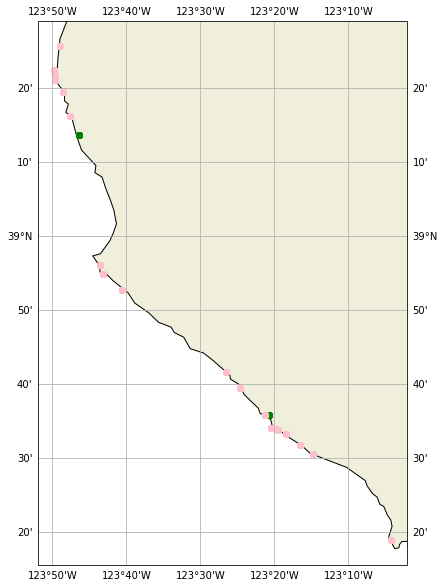

In [451]:
plt.figure(figsize=[8,10])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.plot(sites.Lon,sites.Lat,'o', color = 'red') # site table
plt.plot(sizes.Lon,sizes.Lat,'o',color = 'blue') # size table
plt.plot(counts.Lon,counts.Lat,'o',color = 'green') #counts table
plt.plot(alg_cover.Lon,alg_cover.Lat,'o',color = 'black') #algae cover
plt.plot(sub_cover.Lon,sub_cover.Lat,'o',color = 'pink') #substrate cover

**Make sure that the habitatID and substrateID codes match those provided in the algae and substrate cover tables**

```python

# Manual check to make sure the habitatID and habitat type (descriptions) match the alg_cover and alg_codes tables
dict(zip(alg_cover['HabitatID'], alg_cover['HABITAT']))
dict(zip(alg_codes['HabitatID'], alg_codes['Habitat Type']))

# Manual check to make sure the SubstrateID and Substrate Type (descriptions) match the sub_cover and sub_codes tables
dict(zip(sub_cover['SubstrateID'], sub_cover['Substrate']))
dict(zip(sub_codes['SubstrateID'], sub_codes['Substrate Type']))
```

**Next, make sure that the SpeciesIDs included in the size and counts table exist in the species reference table**

In [452]:
for sp in counts.SpeciesID.unique():
    if len(species[species['SpeciesID'] == sp]) != 1:
        print(sp + ' did not pass QC test')      
print('Species in counts table: QC test passed')

for sp in sizes.SpeciesID.unique():
    if len(species[species['SpeciesID'] == sp]) != 1:
        print(sp + ' did not pass QC test')
print('Species in sizes table: QC test passed')

Species in counts table: QC test passed
Species in sizes table: QC test passed


**Next, check to see if any of the data tables have any NaNs in their relevant data columns.** <br>
Note that there are a number of rows in the counts column where a species was identified but not counted - this is not a problem but good to know. 

In [453]:
print('NaN values in size column of size table:' , len(sizes[sizes['Size'].isna()]))
print('NaN values in Count column of counts table:', len(counts[counts['Count'].isna()]))
print('NaN values in PercentCover column of alg_cover table:', len(alg_cover[alg_cover['PercentCover'].isna()]))
print('NaN values in Percent of Total Area column of sub_cover table:', len(sub_cover[sub_cover['PercentCover'].isna()]))

NaN values in size column of size table: 0
NaN values in Count column of counts table: 638
NaN values in PercentCover column of alg_cover table: 0
NaN values in Percent of Total Area column of sub_cover table: 0


## Run species table through WoRMS

The species table was generated by running it through WoRMS via [pyworms](https://pyworms.readthedocs.io/en/latest/). As a sanity check, I wanted to run it through WoRMS one more time to make sure all species were correctly matched.

This code was run once; since it takes a while to run, I had saved the output to a csv file, which can be opened (see next cell) as opposed to re-running this. 

```python

for index, row in species.iterrows():
    resp = pyworms.aphiaRecordsByMatchNames(row['ScientificName'], marine_only=True)
    
    # When no matches are found, print the non-matching name and move on
    if len(resp[0]) == 0:
        print('\nNo match for name "{}"'.format(row['ScientificName']))
        continue
        
    # When more than 1 match is found, print which one has multiple matches
    elif len(resp[0]) > 1:
        print('\nMultiple matches for name "{}":'.format(row['ScientificName']))
        continue
    
    # When only 1 match is found, put the appropriate information into the appropriate row and column
    else:
        print(f'match found for {row.ScientificName}')
        worms = resp[0][0]
        species.loc[index, 'new_scientificName'] = worms['scientificname']
        species.loc[index, 'new_scientificNameID'] = worms['valid_AphiaID']
        species.loc[index, 'new_kingdom'] = worms['kingdom']
        species.loc[index, 'new_phylum'] = worms['phylum']
        species.loc[index, 'new_class'] = worms['class']
        species.loc[index, 'new_order'] = worms['order']
        species.loc[index, 'new_family'] = worms['family']
        species.loc[index, 'new_genus'] = worms['genus']
        species.loc[index, 'new_rank'] = worms['rank']
        species.loc[index, 'match_type'] = worms['match_type']
```

In [454]:
# CSV file of species list with new columns from PyWORMS output. 
species = pd.read_csv('species_worms_newcolumns_01222024.csv')

In [455]:
species.head(2)

,SpeciesID,CommonName,ScientificName,species_definition,taxonomic_source,taxonomic_id,kingdom,phylum,class,order,...,new_scientificName,new_scientificNameID,new_kingdom,new_phylum,new_class,new_order,new_family,new_genus,new_rank,match_type
0,A0,Abalone species,Haliotis spp.,"abalone, not identified to species level",WoRMS,138050,Animalia,Mollusca,Gastropoda,Lepetellida,...,Haliotis,138050.0,Animalia,Mollusca,Gastropoda,Lepetellida,Haliotidae,Haliotis,Genus,exact
1,A1,Red Abalone,Haliotis rufescens,Haliotis rufescens,WoRMS,445357,Animalia,Mollusca,Gastropoda,Lepetellida,...,Haliotis rufescens,445357.0,Animalia,Mollusca,Gastropoda,Lepetellida,Haliotidae,Haliotis,Species,exact


**Compare the original ScientificName column with the WoRMS query output**

In [456]:
# Good news is that the only difference in scienficNames is the addition of "spp." at the end of entries that are at the genus level.
for index, row in species.iterrows():
    if row['ScientificName'] != row['new_scientificName']:
        print(row['ScientificName'] + ' different from ' + row['new_scientificName'])

Haliotis spp. different from Haliotis
Cancer spp. different from Cancer
Petrolisthes spp. different from Petrolisthes
Pugettia spp. different from Pugettia
Pagurus spp. different from Pagurus
Pugettia spp. different from Pugettia
Pisaster spp. different from Pisaster
Solaster spp. different from Solaster
Sebastes spp. different from Sebastes
Mopalia spp. different from Mopalia
Tegula spp. different from Tegula
Gastroclonium spp. different from Gastroclonium
Urticina spp. different from Urticina
Cliona spp. different from Cliona
Pisaster spp. different from Pisaster
Solaster spp. different from Solaster
Spatangoida spp. different from Spatangoida
Nereis spp. different from Nereis


In [457]:
# Important to note that there is one row where the taxonomic_ID does not match the WoRMS query output.
# This is because that particular species is unaccepted: https://www.marinespecies.org/aphia.php?p=taxdetails&id=599485 
# Since we are using the new_scientificID in our occurrence table, this is OK. 
for index, row in species.iterrows():
    if row['taxonomic_id'] != row['new_scientificNameID']:
        print(row['taxonomic_id'] , ' different from ' , row['new_scientificNameID'])

599485  different from  1723348.0


In [458]:
# Print any rows that don't have an 'exact' match with WoRMS query. Good news, they're all exact matches :)
len(species[species['match_type']!='exact'])

0

## DwC Conversion

For this conversion, we will need three seperate tables:
1. An **event** table, where each event is a dive survey. This should include ALL surveys, from size, count, and habitat % cover observations. This event file will contain hierarchical events for surveys (transects) and sub-samples taken for substrate & algal percent cover estimates. 
2. An **occurrence** table with each occurrence being a unique observation for a unique survey, including absense/presence and organism counts.
3. A **Measurement or Fact Extension** table containing the organism sizes, substrate percent cover, and algal percent cover information.

Some rationale for using an Event Core (as opposed to an Occurrence Core) is summarized on [this page](https://manual.obis.org/formatting.html#when-to-use-event-core)

## Event Core

Each event is defined as a dive survey. The four data tables (sizes, counts, algal cover, substrate cover) don't have entirely overlapping dive surveys (Survey_Num column), meaning not all transects measured all four data parameters. To make sure that my event core table includes all dive surveys from all tables, I generated event files for each data file, then concatenated all 4 event files, and removed duplicate eventIDs. I ran a few QC tests (see below) along the way to make sure all transects and sub-samples were accounted for. <br>

**Handling subsample hierarchy** <br>
Tables with % cover (substrate and algae) have subsamples for certain transects as defined in the Subsample column from both of these tables. To handle this, I used the following terms:
- eventID includes information to distinguish between a sub-sampled event or a full transect, and follows this general logic: If a subsample exists, the eventID follows the format survey:[Survey_Num]_subsample:L or R (left or right). If the event is not a sub-sample, eventID follows the format survey:[Survey_Num]
- eventType distinguishes between a survey or a sub-sample - note that this is not using a controlled vocabulary but instead just free text. 
- If an event is a sub-sample, parentEventID is used identify the full transect corresponding to the sub-sample. 

There is some helpful guidance and examples on handling hierarchical events in an [imaging dataset](https://docs.google.com/spreadsheets/d/1m5Udf0uHcdO27hA00CvIMj4Lq7M9Ljx4HyOugbjHqng/edit#gid=0). <br>


**Event Core: sizes**

In [459]:
# Make an event table for organism sizes
event_sizes = pd.DataFrame()

# eventID
event_sizes['eventID'] = 'survey:' + sizes['Survey_Num'].astype(str)
# eventType 
event_sizes['eventType'] = 'survey'
# parentEventID - There are no sub-samples in the sizes table, so there is no parent corresponding the survey_nums provided in the eventID. 
event_sizes['parentEventID'] = ''
# eventDate 
event_sizes['eventDate'] = sizes['SurveyDate']
# DFW_short_code - this column will be used to map with the site reference table. 
event_sizes['DFW_short_code'] = sizes['DFW_short_code']
# minimumDepthInMeters
event_sizes['minimumDepthInMeters'] = sizes['MinimumDepth']
# maximumDepthInMeters
event_sizes['maximumDepthInMeters'] = sizes['MaximumDepth']

# Merge additional information from the sites table
event_sizes = pd.merge(event_sizes, sites[['DFW_short_code', 'Lat', 'Lon', 'SiteName', 'ProtectionStatus']], on='DFW_short_code', how='left')
# Drop duplicate eventIDs 
event_sizes = event_sizes.drop_duplicates(subset='eventID')

#QC check:
if len(event_sizes) != len(sizes.Survey_Num.unique()):
    print('failed')
else:
    print('passed')

passed


In [460]:
event_sizes.head(2)

,eventID,eventType,parentEventID,eventDate,DFW_short_code,minimumDepthInMeters,maximumDepthInMeters,Lat,Lon,SiteName,ProtectionStatus
0,survey:ALB18-A1-1,survey,,8/30/2018,ALB,12.0,16.0,39.228024,-123.773516,Albion Bay,non-MPA
3,survey:ALB18-A1-2,survey,,8/30/2018,ALB,8.0,8.0,39.228024,-123.773516,Albion Bay,non-MPA


**Event Core: counts**

In [461]:
# Make an event table for organism counts
event_counts = pd.DataFrame()

# eventID
event_counts['eventID'] = 'survey:' + counts['SurveyNum'].astype(str)
#eventType
event_counts['eventType'] = 'survey'
# parentEventID - There are no sub-samples in the counts table, so there is no parent corresponding the survey_nums provided in the eventID. 
event_counts['parentEventID'] = '' 
# eventDate
event_counts['eventDate'] = counts['SurveyDate']
# DFW_short_code - this column will be used to map with the site reference table. 
event_counts['DFW_short_code'] = counts['DFW_short_code']
# minimumDepthInMeters
event_counts['minimumDepthInMeters'] = counts['MinimumDepth']
# maximumDepthInMeters
event_counts['maximumDepthInMeters'] = counts['MaximumDepth']

# Merge additional information from the sites table
event_counts = pd.merge(event_counts, sites[['DFW_short_code', 'Lat', 'Lon', 'SiteName', 'ProtectionStatus']], on='DFW_short_code', how='left')
# Drop duplicate eventIDs 
event_counts = event_counts.drop_duplicates(subset='eventID')

#QC check:
if len(event_counts) != len(counts.SurveyNum.unique()):
    print('failed')
else:
    print('passed')

passed


In [462]:
event_counts.head(2)

,eventID,eventType,parentEventID,eventDate,DFW_short_code,minimumDepthInMeters,maximumDepthInMeters,Lat,Lon,SiteName,ProtectionStatus
0,survey:ALB18-A1-3,survey,,8/20/2018,ALB,11.0,14.0,39.228024,-123.773516,Albion Bay,non-MPA
15,survey:ALB18-A1-4,survey,,8/30/2018,ALB,4.0,7.0,39.228024,-123.773516,Albion Bay,non-MPA


**Event Core: algal cover**

In [463]:
# Define some empty lists 
event_ids = []
types = []
parent_event_ids = []
dates = []
short_codes = []
min_depths = []
max_depths = []

for index, row in alg_cover.iterrows():
    # Loop through each row in the algae % cover and if there is a subsample, include that as part of the event_ID string. 
    if row['Subsample'] in ['L', 'R']: 
        event_id = 'survey:' + str(alg_cover.loc[index, 'Survey_Num']) + '_subsample:' + row['Subsample']
        # Specify the eventType
        type_name = 'sub-sample'
        parent_event_id = 'survey:' + str(alg_cover.loc[index, 'Survey_Num'])
        event_date = '' # if we have a subsample, the date will be with the parent
        short_code = '' # if we have a subsample, the DFW_short_code will be with the parent
        min_depth = '' # if we have a subsample, the minimum depth will be with the parent
        max_depth = '' # if we have a subsample, the maximum depth will be with the parent
    
    # If the row is not a subsample:  
    else: 
        event_id = 'survey:' + str(alg_cover.loc[index, 'Survey_Num'])
        type_name = 'survey'
        parent_event_id = ''
        event_date = alg_cover.loc[index, 'SurveyDate']
        short_code = alg_cover.loc[index, 'DFW_short_code']
        min_depth = alg_cover.loc[index, 'MinimumDepth']
        max_depth = alg_cover.loc[index, 'MaximumDepth']
    
    # Add in the correct values into the empty lists
    event_ids.append(event_id)
    types.append(type_name)
    parent_event_ids.append(parent_event_id)
    dates.append(event_date)
    short_codes.append(short_code)
    min_depths.append(min_depth)
    max_depths.append(max_depth)

In [464]:
# Now make a dataframe with populated fields 
event_alg = pd.DataFrame()
# eventID
event_alg['eventID'] = event_ids
# eventType
event_alg['eventType'] = types
# parentEventID
event_alg['parentEventID'] = parent_event_ids
# eventDate
event_alg['eventDate'] = dates
# DFW_short_code - this column will be used to map with the site reference table. 
event_alg['DFW_short_code'] = short_codes
# minimumDepthInMeters
event_alg['minimumDepthInMeters'] = min_depths
# maximumDepthInMeters
event_alg['maximumDepthInMeters'] = max_depths

# Merge with sites table to get event-level information
event_alg = pd.merge(event_alg, sites[['DFW_short_code', 'Lat', 'Lon', 'SiteName', 'ProtectionStatus']], on='DFW_short_code', how='left')
# remove duplicate rows
event_alg = event_alg.drop_duplicates(subset='eventID')

# Currently for the sub-samples, the lat, lon, sitename and protectionstatus are NaNs. These should be empty rows ''
event_alg.fillna('', inplace=True)

In [465]:
event_alg.head(2)

,eventID,eventType,parentEventID,eventDate,DFW_short_code,minimumDepthInMeters,maximumDepthInMeters,Lat,Lon,SiteName,ProtectionStatus
0,survey:BR99-01,survey,,7/29/1999,BR,39.0,39.0,38.315361,-123.071539,Bodega Marine Life Refuge (BML),no take MPA
5,survey:BR99-02,survey,,7/29/1999,BR,52.0,52.0,38.315361,-123.071539,Bodega Marine Life Refuge (BML),no take MPA


In [466]:
# Now I need to make sure that parentIDs are also included for sub-samples. 
# Make a new DF with event-level information for sub-sampled parent IDs, and then concatenate it to the one above. 

survey_nums = []
dfw_codes = []
dates = []
min_depths = []
max_depths = []

for index, row in event_alg.iterrows():
    if row['eventType'] in ['sub-sample']:
        survey_num = event_alg.loc[index, 'parentEventID'].split(':')[-1] # get the parent ID (Survey_Num)
        survey_nums.append(survey_num)
        
        matching_row = alg_cover[alg_cover['Survey_Num'] == survey_num].head(1)

        dfw_code = matching_row['DFW_short_code'].values[0]
        dfw_codes.append(dfw_code)
        
        event_date = matching_row['SurveyDate'].values[0]
        dates.append(event_date)
        
        min_depth = matching_row['MinimumDepth'].values[0]
        min_depths.append(min_depth)
        
        max_depth = matching_row['MaximumDepth'].values[0]
        max_depths.append(max_depth)


# Now make a dataframe with this information, and lastly, concetenate it with the existing event_alg dataframe.
event_alg_subs = pd.DataFrame()
event_alg_subs['eventID'] = survey_nums
event_alg_subs['eventID'] = 'survey:' + event_alg_subs['eventID']
event_alg_subs['eventType'] = 'survey'
event_alg_subs['parentEventID'] = ''
event_alg_subs['eventDate'] = dates
event_alg_subs['DFW_short_code'] = dfw_codes
event_alg_subs['minimumDepthInMeters'] = min_depths
event_alg_subs['maximumDepthInMeters'] = max_depths

event_alg_subs = pd.merge(event_alg_subs, sites[['DFW_short_code', 'Lat', 'Lon', 'SiteName', 'ProtectionStatus']], on='DFW_short_code', how='left')

# There are duplicates because there are when a transect is subsampled, there are 2 subsamples (L and R).
event_alg_subs = event_alg_subs.drop_duplicates(subset='eventID')

In [467]:
# Now concatenate both algal cover event tables
event_alg_final = pd.concat([event_alg, event_alg_subs])
event_alg_final.reset_index(drop=True, inplace=True)

In [468]:
# There are a few duplicates at surveys where both subsamples and non-subsample surveys were done.
# Since eventIDs should be unique, we can remove these duplicates. 
duplicate_eventID = event_alg_final[event_alg_final.duplicated(subset=['eventID'])]

print("Duplicate eventID values in event_alg_final:")
print(duplicate_eventID['eventID'])

Duplicate eventID values in event_alg_final:
2263     survey:CC11-D7
2412     survey:PC03-D9
2532    survey:TC06-AA8
2536    survey:TC06-B04
2559     survey:TP06-B2
2610     survey:VD03-C3
Name: eventID, dtype: object


In [469]:
# Remove duplicates
event_alg_final = event_alg_final.drop_duplicates(subset='eventID')

In [470]:
#QC check to make sure that the number of unique Survey_Nums in alg_cover and in event_alg_final surveys are the same:
if len(event_alg_final[event_alg_final['eventType'] == 'survey']) != len(alg_cover.Survey_Num.unique()):
    print('failed')
else:
    print('passed')

passed


In [471]:
event_alg_final.head(2)

,eventID,eventType,parentEventID,eventDate,DFW_short_code,minimumDepthInMeters,maximumDepthInMeters,Lat,Lon,SiteName,ProtectionStatus
0,survey:BR99-01,survey,,7/29/1999,BR,39.0,39.0,38.315361,-123.071539,Bodega Marine Life Refuge (BML),no take MPA
1,survey:BR99-02,survey,,7/29/1999,BR,52.0,52.0,38.315361,-123.071539,Bodega Marine Life Refuge (BML),no take MPA


**Event Core: substrate cover** <br>
This table includes sub-surveys for certain rows, identified as "L" or "R" transects if they are subsamples, similar to the algae % cover.

In [472]:
# Define some empty lists 
event_ids = []
types = []
parent_event_ids = []
dates = []
short_codes = []
min_depths = []
max_depths = []

for index, row in sub_cover.iterrows():
    # If the row is a subsample:
    if row['Subsample'] in ['L', 'R']: 
        event_id = 'survey:' + str(sub_cover.loc[index, 'Survey_Num']) + '_subsample:' + row['Subsample']
        type_name = 'sub-sample'
        parent_event_id = 'survey:' + str(sub_cover.loc[index, 'Survey_Num'])
        event_date = '' # if we have a subsample, the date will be with the parent
        short_code = '' # if we have a subsample, the DFW_short_code will be with the parent
        min_depth = '' # if we have a subsample, the minimum depth will be with the parent (the transect-level measurements are not taken at the sub-sample level)
        max_depth = '' # if we have a subsample, the maximum depth will be with the parent
    # If the row is not a subsample:  
    else: 
        event_id = 'survey:' + str(sub_cover.loc[index, 'Survey_Num'])
        type_name = 'survey'
        parent_event_id = ''
        event_date = sub_cover.loc[index, 'SurveyDate']
        short_code = sub_cover.loc[index, 'DFW_short_code']
        min_depth = sub_cover.loc[index, 'MinimumDepth']
        max_depth = sub_cover.loc[index, 'MaximumDepth']
        
    # Now add in the correct values into the empty lists
    event_ids.append(event_id)
    types.append(type_name)
    parent_event_ids.append(parent_event_id)
    dates.append(event_date)
    short_codes.append(short_code)
    min_depths.append(min_depth)
    max_depths.append(max_depth)

In [473]:
# Now make a dataframe with populated fields 
event_sub = pd.DataFrame()
event_sub['eventID'] = event_ids
event_sub['eventType'] = types
event_sub['parentEventID'] = parent_event_ids
event_sub['eventDate'] = dates
event_sub['DFW_short_code'] = short_codes
event_sub['minimumDepthInMeters'] = min_depths
event_sub['maximumDepthInMeters'] = max_depths

# Merge with sites table to get event-level information
event_sub = pd.merge(event_sub, sites[['DFW_short_code', 'Lat', 'Lon', 'SiteName', 'ProtectionStatus']], on='DFW_short_code', how='left')

# remove duplicate rows
event_sub = event_sub.drop_duplicates(subset='eventID')

# Currently for the sub-samples, the lat, lon, siteName and protectionStatus are NaNs. These should be empty rows ''
event_sub.fillna('', inplace=True)

In [474]:
# Now I need to make sure that parentIDs are also included for sub-samples. 
# Make a new DF with event-level information for sub-sample parent IDs, and then append it to the one above. 

survey_nums = []
dfw_codes = []
dates = []
min_depths = []
max_depths = []

for index, row in event_sub.iterrows():
    if row['eventType'] in ['sub-sample']:
        survey_num = event_sub.loc[index, 'parentEventID'].split(':')[-1] # get the parent ID (Survey_Num)
        survey_nums.append(survey_num)
        
        matching_row = sub_cover[sub_cover['Survey_Num'] == survey_num].head(1)

        dfw_code = matching_row['DFW_short_code'].values[0]
        dfw_codes.append(dfw_code)
        
        event_date = matching_row['SurveyDate'].values[0]
        dates.append(event_date)
        
        min_depth = matching_row['MinimumDepth'].values[0]
        min_depths.append(min_depth)
        
        max_depth = matching_row['MaximumDepth'].values[0]
        max_depths.append(max_depth)

# Now make a dataframe with this information, and lastly, concetenate it with the existing event_alg dataframe.
event_sub_subs = pd.DataFrame()
event_sub_subs['eventID'] = survey_nums
event_sub_subs['eventID'] = 'survey:' + event_sub_subs['eventID']
event_sub_subs['eventType'] = 'survey'
event_sub_subs['parentEventID'] = ''
event_sub_subs['eventDate'] = dates
event_sub_subs['DFW_short_code'] = dfw_codes
event_sub_subs['minimumDepthInMeters'] = min_depths
event_sub_subs['maximumDepthInMeters'] = max_depths

event_sub_subs = pd.merge(event_sub_subs, sites[['DFW_short_code', 'Lat', 'Lon', 'SiteName', 'ProtectionStatus']], on='DFW_short_code', how='left')

# There are duplicates because there are when a transect is subsampled, there are 2 subsamples (L and R).
event_sub_subs = event_sub_subs.drop_duplicates(subset='eventID')

In [475]:
# Now concatenate both algal cover event tables
event_sub_final = pd.concat([event_sub, event_sub_subs])
event_sub_final.reset_index(drop=True, inplace=True)

In [476]:
# There are no duplicate eventIDs in final substrate event table 
duplicate_eventID = event_sub_final[event_sub_final.duplicated(subset=['eventID'])]

print("Duplicate eventID values in event_alg_final:")
print(duplicate_eventID['eventID'])

Duplicate eventID values in event_alg_final:
Series([], Name: eventID, dtype: object)


In [477]:
#QC check to make sure that the number of unique Survey_Nums in alg_cover and in event_alg_final surveys are the same:
if len(event_sub_final[event_sub_final['eventType'] == 'survey']) != len(sub_cover.Survey_Num.unique()):
    print('failed')
else:
    print('passed')

passed


In [478]:
event_sub_final.head(2)

,eventID,eventType,parentEventID,eventDate,DFW_short_code,minimumDepthInMeters,maximumDepthInMeters,Lat,Lon,SiteName,ProtectionStatus
0,survey:BR99-01,survey,,7/29/1999,BR,39.0,39.0,38.315361,-123.071539,Bodega Marine Life Refuge (BML),no take MPA
1,survey:BR99-02,survey,,7/29/1999,BR,52.0,52.0,38.315361,-123.071539,Bodega Marine Life Refuge (BML),no take MPA


**Concatenate event cores from each data table into a single table**

In [479]:
events_concat = pd.concat([event_sizes, event_counts, event_alg_final, event_sub_final], ignore_index=True)

event = events_concat.drop_duplicates(subset='eventID')

In [480]:
np.shape(event)

(4097, 11)

In [481]:
# locationRemarks
event.loc[(event['ProtectionStatus'] == 'non-MPA'), 'ProtectionStatus'] = 'This site is not in a Marine Protected Area'
event.loc[(event['ProtectionStatus'] == 'no take MPA'), 'ProtectionStatus'] = 'This site is in a no-take Marine Protected Area'
event.loc[(event['ProtectionStatus'] == 'no commercial red sea urchin fishing'), 'ProtectionStatus'] = 'This site is located in an area that prohibits commercial red sea urchin fishing'
event.loc[(event['ProtectionStatus'] == 'no recreational abalone fishing after 2014'), 'ProtectionStatus'] = 'This site is located in an area that prohibited abalone fishing after 2014'

/tmp/ipykernel_11/706232930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event.loc[(event['ProtectionStatus'] == 'non-MPA'), 'ProtectionStatus'] = 'This site is not in a Marine Protected Area'
/tmp/ipykernel_11/706232930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event.loc[(event['ProtectionStatus'] == 'no take MPA'), 'ProtectionStatus'] = 'This site is in a no-take Marine Protected Area'
/tmp/ipykernel_11/706232930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [482]:
# locationRemarks
event.rename(columns = {'ProtectionStatus':'locationRemarks'}, inplace=True)
event.head(2)

/tmp/ipykernel_11/3827239244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event.rename(columns = {'ProtectionStatus':'locationRemarks'}, inplace=True)


,eventID,eventType,parentEventID,eventDate,DFW_short_code,minimumDepthInMeters,maximumDepthInMeters,Lat,Lon,SiteName,locationRemarks
0,survey:ALB18-A1-1,survey,,8/30/2018,ALB,12.0,16.0,39.228024,-123.773516,Albion Bay,This site is not in a Marine Protected Area
1,survey:ALB18-A1-2,survey,,8/30/2018,ALB,8.0,8.0,39.228024,-123.773516,Albion Bay,This site is not in a Marine Protected Area


In [483]:
# QC test here to make sure that the number of unique eventIDs match the number of unique survey_num values across all tables

print('number of unique transects in concatenated event table = ', len(events_concat[events_concat['eventType'] == 'survey']['eventID'].unique()))

all_surveys = np.concatenate([
    np.array(counts.SurveyNum.unique()), 
    np.array(sizes.Survey_Num.unique()),
    np.array(alg_cover.Survey_Num.unique()),
    np.array(sub_cover.Survey_Num.unique())
])

print('number of unique transects from all data tables =', len(np.unique(all_surveys)))

number of unique transects in concatenated event table =  3174
number of unique transects from all data tables = 3174


In [484]:
## Add a few other important Darwin Core Terms. The pandas warning messages can be ignored

# stateProvince
event['stateProvince'] = 'California'
# countryCode
event['countryCode'] = 'US'
# geodeticDatum 
event['geodeticDatum'] = 'WGS84' 

/tmp/ipykernel_11/2798431912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['stateProvince'] = 'California'
/tmp/ipykernel_11/2798431912.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['countryCode'] = 'US'
/tmp/ipykernel_11/2798431912.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [485]:
# reset index 
event.reset_index(drop=True, inplace=True)

In [486]:
event.head(2)

,eventID,eventType,parentEventID,eventDate,DFW_short_code,minimumDepthInMeters,maximumDepthInMeters,Lat,Lon,SiteName,locationRemarks,stateProvince,countryCode,geodeticDatum
0,survey:ALB18-A1-1,survey,,8/30/2018,ALB,12.0,16.0,39.228024,-123.773516,Albion Bay,This site is not in a Marine Protected Area,California,US,WGS84
1,survey:ALB18-A1-2,survey,,8/30/2018,ALB,8.0,8.0,39.228024,-123.773516,Albion Bay,This site is not in a Marine Protected Area,California,US,WGS84


**Convert time to ISO standard**

In [487]:
for index, row in event.iterrows():
    if row['eventDate'] != '':
        event_date = pd.to_datetime(row['eventDate'], format="%m/%d/%Y")
        event_date = event_date.date()
        event.at[index, 'eventDate'] = event_date

In [488]:
event['eventDate'].head()

0    2018-08-30
1    2018-08-30
2    2018-08-20
3    2018-08-30
4    2018-08-30
Name: eventDate, dtype: object

**Rename several columns to match Darwin Core terms**

In [489]:
event.rename(columns={
            'Lat':'decimalLatitude',
            'Lon':'decimalLongitude',
            'SiteName':'locality'
                     }, inplace=True)

event.drop(columns = ['DFW_short_code'], inplace=True)

/tmp/ipykernel_11/3531654147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event.rename(columns={
/tmp/ipykernel_11/3531654147.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event.drop(columns = ['DFW_short_code'], inplace=True)


In [490]:
# Include the samplingProtocol term for left/right sub-samples or for full surveys:

event['samplingProtocol'] = ''

event.loc[(event['eventType'] == 'survey'), 'samplingProtocol'] = 'Scuba diving surveys are conducted along transects measuring 30 x 2m. Data collected on the transects include depth of transect, number, size and species of abalone and urchins, number of associated species and predators, substrate percent cover, and algal type percent cover.'

event.loc[event['eventID'].str.contains('subsample:R'), 'samplingProtocol'] = 'Scuba diving surveys are conducted along transects measuring 30 x 2m. This event contains just the right side of the transect (30 x 1m). Data collected on these sub-sampled transects include substrate percent cover and algal type percent cover.'

event.loc[event['eventID'].str.contains('subsample:L'), 'samplingProtocol'] = 'Scuba diving surveys are conducted along transects measuring 30 x 2m. This event contains just the left side of the transect (30 x 1m). Data collected on these sub-sampled transects include substrate percent cover and algal type percent cover.'

/tmp/ipykernel_11/1631817208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event['samplingProtocol'] = ''


In [491]:
# make sure eventIDs are all unique
np.shape(event), len(event['eventID'].unique())

((4097, 14), 4097)

In [492]:
# Sort the event table by date, and then by eventID to make it more tidy
event.sort_values(by=['eventDate', 'eventID'], inplace=True)

/tmp/ipykernel_11/3709229603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event.sort_values(by=['eventDate', 'eventID'], inplace=True)


In [493]:
# Reset Index
event.reset_index(inplace=True, drop=True)

In [494]:
event.head(2)

,eventID,eventType,parentEventID,eventDate,minimumDepthInMeters,maximumDepthInMeters,decimalLatitude,decimalLongitude,locality,locationRemarks,stateProvince,countryCode,geodeticDatum,samplingProtocol
0,survey:PA71C-06,survey,,1971-09-01,15.2,16.8,38.914356,-123.719536,Point Arena,This site is not in a Marine Protected Area,California,US,WGS84,Scuba diving surveys are conducted along trans...
1,survey:PA71C-07,survey,,1971-09-01,4.6,7.6,38.914356,-123.719536,Point Arena,This site is not in a Marine Protected Area,California,US,WGS84,Scuba diving surveys are conducted along trans...


## Occurrence table

The occurrence table contains information from the counts table, including: 
- organism counts for each survey corresponding to WoRMS IDs
- vitality information (dead vs alive)

In [495]:
# QC test: Get # of events that are in the sizes table but not in the counts table
sizes_not_in_counts = [value for value in sizes['Survey_Num'].unique() if value not in counts['SurveyNum'].unique()]
print('There are', len(sizes_not_in_counts), 'transects where size was measured, but species was not counted.')

# Another test (redundant) to make sure all of the survey_nums in the sizes table are in the counts table. 
sizes_in_counts = [value for value in counts['SurveyNum'].unique() if value in sizes['Survey_Num'].unique()]
print(sizes['Survey_Num'].isin(counts['SurveyNum']).all())

There are 0 transects where size was measured, but species was not counted.
True


In [496]:
# Make new dataframe
occ = pd.DataFrame()

# Pull eventIDs from counts table
occ['eventID'] = 'survey:' + counts['SurveyNum']

# Pull speciesID from counts table
occ['SpeciesID'] = counts['SpeciesID']

# Pull individualCount from counts table
occ['individualCount'] = counts['Count']#.astype('Int64')

# Pull occurrenceStatus from counts table
occ['occurrenceStatus'] = counts['Presence']

In [497]:
occ.head(2)

,eventID,SpeciesID,individualCount,occurrenceStatus
0,survey:ALB18-A1-3,A1,4.0,present
1,survey:ALB18-A1-3,DA12,0.0,absent


In [498]:
# For the EMOF table, I'll need a common identifier to map the species observed in a transect with the sizes information.
occ['events_species_ID'] = 'event_' + occ['eventID'].astype(str) +'_sp_' + occ['SpeciesID'].astype(str)

In [499]:
# merge occ with species table to get QC'ed WoRMS information
occ = pd.merge(occ, species[['SpeciesID', 
                       'new_scientificName',
                       'CommonName',
                       'new_kingdom',
                       'new_phylum',
                       'new_class',
                       'new_order',
                       'new_family',
                       'new_genus',
                       'new_rank',
                       'new_scientificNameID']], on='SpeciesID', how='left')

In [500]:
# reformat scientificNameID
occ['scientificNameID'] = 'urn:lsid:marinespecies.org:taxname:' + occ['new_scientificNameID'].astype(int).astype(str)

In [501]:
# rename columns to align with DwC terms
occ.rename(columns={
            'new_scientificName':'scientificName',
            'new_kingdom':'kingdom',
            'new_phylum':'phylum',
            'new_class':'class',
            'new_order':'order',
            'new_family':'family',
            'new_genus':'genus',
            'new_rank':'taxonRank',
            'CommonName':'vernacularName'
                     }, inplace=True)

In [502]:
# Drop unnecessary columns
occ.drop(columns = ['SpeciesID', 'new_scientificNameID'], inplace=True)

In [503]:
# Another test here to make sure that all of the eventIDs in the occurrence table are present in the event table. 

# Extract unique event IDs from the first table
unique_eventIDs_occ = set(occ['eventID'].unique())

# Extract unique event IDs from the second table
unique_eventIDs_event = set(event['eventID'].unique())

# Check if all event IDs from the first table are present in the second table
if unique_eventIDs_occ.issubset(unique_eventIDs_event):
    print("All unique eventIDs from the occurrence table are present in the events table.")
else:
    print("QC test failed")

All unique eventIDs from the occurrence table are present in the events table.


In [504]:
# Add a few other terms
occ['datasetName'] = 'Bull Kelp Forest Ecosystem Monitoring Database, Northern California'
occ['basisOfRecord'] = 'HumanObservation'

**Add vitality column to specify dead organisms** <br>
There are a number of speciesIDs associated with dead organisms, which we can specify using the 'vitality' DwC term. Note that the speciesIDs with dead organisms associated with them are recent (past 2010) so it doesn't make sense to make the assumption that all other observations were of living organisms. All that to say, I'll only specify 'dead' but not 'alive'. <br><br>
I am going to define dead species as those with the word "Dead" or "Empty" in their Common Name

In [505]:
dead_sp = species[species['CommonName'].str.contains('Dead|Empty')].CommonName.unique()
dead_sp

array(['Dead Red Abalone', 'Dead Red Abalone (with meat)',
       'Dead Kelp Crab', 'Dead Gumboot Chiton', 'Dead Pisaster species',
       'Dead Solaster species', 'Dead Leather Star', 'Dead Bat Star',
       'Dead Rainbow Star', 'Dead Sunflower Star', 'Dead Red Urchin',
       'Dead Purple Urchin', 'Dead Sea Cucumber',
       'Empty Red Abalone Shell', 'Empty Flat Abalone Shell',
       'Empty Pinto Abalone Shell', 'Empty Purple Urchin Test'],
      dtype=object)

In [506]:
occ['vitality'] = ''
occ.loc[occ['vernacularName'].isin(dead_sp), 'vitality'] = 'dead'

In [507]:
print('Number of dead occurrences:',len(occ[occ['vitality'] == 'dead']))
print('Number of total occurrences:',len(occ))

Number of dead occurrences: 1709
Number of total occurrences: 26031


**Aligning vernacular names** <br>
Some of the common names need to be cleaned - the pyworms response doesn't provide the vernacularName, but since there aren't too many that need to be cleaned up, it's managable to manually handle. The main ones to change are the dead/dying ones, and some that have descriptive test, e.g. "with meat" or "general".

In [508]:
occ.loc[occ['vernacularName'] == 'Decorator crab (general)', 'vernacularName'] = 'Decorator crab'
occ.loc[occ['vernacularName'] == 'Dead Red Abalone', 'vernacularName'] = 'Red Abalone'
occ.loc[occ['vernacularName'] == 'Dying Red Abalone', 'vernacularName'] = 'Red Abalone'
occ.loc[occ['vernacularName'] == 'Dead Red Abalone (with meat)', 'vernacularName'] = 'Red Abalone'
occ.loc[occ['vernacularName'] == 'Dead Kelp Crab', 'vernacularName'] = 'Kelp Crab'
occ.loc[occ['vernacularName'] == 'Dead Gumboot Chiton', 'vernacularName'] = 'Gumboot Chiton'
occ.loc[occ['vernacularName'] == 'Dead Pisaster species', 'vernacularName'] = 'Pisaster species'
occ.loc[occ['vernacularName'] == 'Dead Solaster species', 'vernacularName'] = 'Solaster species'
occ.loc[occ['vernacularName'] == 'Dead Leather Star', 'vernacularName'] = 'Leather Star'
occ.loc[occ['vernacularName'] == 'Dead Bat Star', 'vernacularName'] = 'Bat Star'
occ.loc[occ['vernacularName'] == 'Dead Rainbow Star', 'vernacularName'] = 'Rainbow Star'
occ.loc[occ['vernacularName'] == 'Dead Sunflower Star', 'vernacularName'] = 'Sunflower Star'
occ.loc[occ['vernacularName'] == 'Dead Red Urchin', 'vernacularName'] = 'Red Urchin'
occ.loc[occ['vernacularName'] == 'Dead Purple Urchin', 'vernacularName'] = 'Purple Urchin'
occ.loc[occ['vernacularName'] == 'Dead Sea Cucumber', 'vernacularName'] = 'Sea Cucumber'
occ.loc[occ['vernacularName'] == 'Empty Red Abalone Shell', 'vernacularName'] = 'Red Abalone'
occ.loc[occ['vernacularName'] == 'Empty Flat Abalone Shell', 'vernacularName'] = 'Flat Abalone'
occ.loc[occ['vernacularName'] == 'Empty Pinto Abalone Shell', 'vernacularName'] = 'Pinto Abalone'
occ.loc[occ['vernacularName'] == 'Empty Purple Urchin Test', 'vernacularName'] = 'Purple Urchin'
occ.loc[occ['vernacularName'] == 'Keyhole Limpet (Rough)', 'vernacularName'] = 'Rough Keyhole Limpet'
occ.loc[occ['vernacularName'] == 'Pink Tunicate (Solitary)', 'vernacularName'] = 'Pink Tunicate'
occ.loc[occ['vernacularName'] == 'Clear Tunicate (Solitary)', 'vernacularName'] = 'Clear Tunicate'
occ.loc[occ['vernacularName'] == 'Seastars', 'vernacularName'] = 'Seastar'
occ.loc[occ['vernacularName'] == 'Wasting Star', 'vernacularName'] = 'Seastar'
occ.loc[occ['vernacularName'] == 'Wasting Bat Star', 'vernacularName'] = 'Bat Star'
# got vernacular name from worms: https://www.marinespecies.org/aphia.php?p=taxdetails&id=529633#vernaculars
occ.loc[occ['vernacularName'] == 'Pseudocnus (Cucumeria) spp.', 'vernacularName'] = 'Aggregating Sea Cucumber'

In [509]:
# Create occurrence IDs 

occ['occurrenceID'] = occ.groupby('eventID').cumcount()+1
occ['occurrenceID'] = occ['eventID'] + '_occ' + occ['occurrenceID'].astype(str)

print(occ.shape)

(26031, 18)


In [510]:
occ.head(2)

,eventID,individualCount,occurrenceStatus,events_species_ID,scientificName,vernacularName,kingdom,phylum,class,order,family,genus,taxonRank,scientificNameID,datasetName,basisOfRecord,vitality,occurrenceID
0,survey:ALB18-A1-3,4.0,present,event_survey:ALB18-A1-3_sp_A1,Haliotis rufescens,Red Abalone,Animalia,Mollusca,Gastropoda,Lepetellida,Haliotidae,Haliotis,Species,urn:lsid:marinespecies.org:taxname:445357,Bull Kelp Forest Ecosystem Monitoring Database...,HumanObservation,,survey:ALB18-A1-3_occ1
1,survey:ALB18-A1-3,0.0,absent,event_survey:ALB18-A1-3_sp_DA12,Haliotis rufescens,Red Abalone,Animalia,Mollusca,Gastropoda,Lepetellida,Haliotidae,Haliotis,Species,urn:lsid:marinespecies.org:taxname:445357,Bull Kelp Forest Ecosystem Monitoring Database...,HumanObservation,dead,survey:ALB18-A1-3_occ2


In [511]:
# Make sure all occurrence IDs are unique
len(occ['occurrenceID'].unique()), len(occ)

(26031, 26031)

In [512]:
# Change pd.nan values to empty strings for the individualCounts (when counts were not taken)
occ.loc[pd.isna(occ['individualCount']), 'individualCount'] = ''

In [513]:
# Convert counts to integers (not floats)
for index, row in occ.iterrows():
    if row['individualCount'] != '':
        try:
            int_value = int(row['individualCount'])
            occ.at[index, 'individualCount'] = int_value
        except ValueError:
            print(f"Error with index {index}")

In [514]:
# print rows with nans - note that there as 628 rows where a species was identified but not counted.
# also some higher order rankings aren't available, this is normal.
# do this for all columns of all tables
occ.isna().sum()

eventID                 0
individualCount         0
occurrenceStatus        0
events_species_ID       0
scientificName          0
vernacularName          0
kingdom                 0
phylum                  0
class                   0
order                 971
family                965
genus                1040
taxonRank               0
scientificNameID        0
datasetName             0
basisOfRecord           0
vitality                0
occurrenceID            0
dtype: int64

In [515]:
# reorder column names to be more intuitive
occ_order = ['eventID', 'occurrenceID', 'scientificName', 'vernacularName', 'occurrenceStatus', 'individualCount',
            'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'taxonRank', 'scientificNameID',
             'datasetName', 'basisOfRecord', 'vitality', 'events_species_ID'] 

occ = occ[occ_order]

In [516]:
occ.head(2)

,eventID,occurrenceID,scientificName,vernacularName,occurrenceStatus,individualCount,kingdom,phylum,class,order,family,genus,taxonRank,scientificNameID,datasetName,basisOfRecord,vitality,events_species_ID
0,survey:ALB18-A1-3,survey:ALB18-A1-3_occ1,Haliotis rufescens,Red Abalone,present,4,Animalia,Mollusca,Gastropoda,Lepetellida,Haliotidae,Haliotis,Species,urn:lsid:marinespecies.org:taxname:445357,Bull Kelp Forest Ecosystem Monitoring Database...,HumanObservation,,event_survey:ALB18-A1-3_sp_A1
1,survey:ALB18-A1-3,survey:ALB18-A1-3_occ2,Haliotis rufescens,Red Abalone,absent,0,Animalia,Mollusca,Gastropoda,Lepetellida,Haliotidae,Haliotis,Species,urn:lsid:marinespecies.org:taxname:445357,Bull Kelp Forest Ecosystem Monitoring Database...,HumanObservation,dead,event_survey:ALB18-A1-3_sp_DA12


## EMOF Table

This table will consist of additional event level measurements:
- **organism sizes**: this information is pulled from the sizes table, and mapping with occurrence_id is done by merging with the occurrence table by the events_species_ID column. This is important because the counts table has unique SpeciesIDs for each SurveyNum, but in the sizes table, there are multiple instances of SpeciesID for each SurveyNum. The events_species_ID allows the size information to be mapped properly. Note that there will be multiple rows for the same occurrenceID, since a single occurrence can have multiple organisms counted and measured. 
- **% cover substrate**: Some of these transects include subsamples (L and R), which add up to (approximately) 100%. 
- **% cover algae**: Some of these transects include subsamples (L and R). Note that these can exceed 100% because algae cover can overlap.

**EMOF - organism sizes**

In [517]:
# Generate an events_species_ID column combining transect number + species ID
sizes['events_species_ID'] = 'event_survey:' + sizes['Survey_Num'].astype(str) +'_sp_' + sizes['SpeciesID'].astype(str)

In [518]:
# Generate emof table and add key size and units columns 
emof_sizes = pd.DataFrame()
emof_sizes['events_species_ID'] = sizes['events_species_ID']
# measurementValue
emof_sizes['measurementValue'] = sizes['Size']
# measurementUnit
emof_sizes['measurementUnit'] = 'mm'
# measurementType
emof_sizes['measurementType'] = 'length'
# measurementTypeID
emof_sizes['measurementTypeID'] = 'http://vocab.nerc.ac.uk/collection/P24/current/LENGTH/'
# measurementUnitID
emof_sizes['measurementUnitID'] = 'http://vocab.nerc.ac.uk/collection/P06/current/UXMM/'
# measurementMethod
emof_sizes['measurementMethod'] = 'Sizes of observed organisms were measured from scuba divers along 30 x 2m transects. For abalone, the longest diameter was used to measure size for and for urchins, test width with spines excluded was used to measure size.' 

In [519]:
# Now merge emof with the occ based on event_speciesID to get occurrenceID and eventID corresponding to each size measurement.
emof_sizes = pd.merge(emof_sizes, occ[['events_species_ID', 'eventID', 'occurrenceID']], on='events_species_ID', how='left')

In [520]:
# We now no longer need the events_species_ID in the occurrence and emof tables.
emof_sizes.drop(columns = ['events_species_ID'], inplace=True)
occ.drop(columns = ['events_species_ID'], inplace=True)

In [521]:
# Sizes are all rounded to the nearest mm, so can be treated as integers
emof_sizes['measurementValue'] = emof_sizes['measurementValue'].astype(int)

In [522]:
emof_sizes.head(2)

,measurementValue,measurementUnit,measurementType,measurementTypeID,measurementUnitID,measurementMethod,eventID,occurrenceID
0,145,mm,length,http://vocab.nerc.ac.uk/collection/P24/current...,http://vocab.nerc.ac.uk/collection/P06/current...,Sizes of observed organisms were measured from...,survey:ALB18-A1-1,survey:ALB18-A1-1_occ1
1,205,mm,length,http://vocab.nerc.ac.uk/collection/P24/current...,http://vocab.nerc.ac.uk/collection/P06/current...,Sizes of observed organisms were measured from...,survey:ALB18-A1-1,survey:ALB18-A1-1_occ1


**EMOF - % habitat substrate** <br>
For percent substrate, I'll need to get the survey_num, which matches the eventID in the event core.<br>
This information is at the event level (transect level), so it will not be linked to the occurrenceID, but instead to the eventID. <br><br>
Note that each survey_num should add up to approximately 100%. On Feb 26, found that a considerable number of transects are above 100% (many at 200%). <br>
After talking to Bob, this is because of subsamples (left vs right transects). Subsamples can be "L", "R", or "LR". 

In [523]:
# Make function that calculates the total percent cover for all surveys (or sub-samples) and prints out the max and min.

def cover_totals(df, subsample):
    '''
    Inputs: dataframe to be screened, and the subsample string used, either 'L', 'R' or 'LR'
    Outputs: print statements with min and max total percent covers from all surveys within that survey or subsampling scheme. 
    '''
    df_sub = df[df['Subsample'] == subsample]
    df_surveys = df_sub.Survey_Num.unique()
    
    not_100 = []
    covers = []

    for survey in df_surveys:
        cover_total = np.sum(list(df_sub[df_sub['Survey_Num'] == survey]['PercentCover']))
        if cover_total != 100:
            not_100.append(survey)
            covers.append(cover_total)
            
    print(f'min % cover for {subsample} transects:', np.min(covers))
    print(f'max % cover for {subsample} transects:', np.max(covers)) 
    
#    return list(zip(not_100, covers))


In [524]:
# All are within appropriate range. 
cover_totals(sub_cover, 'L')
cover_totals(sub_cover, 'R')
cover_totals(sub_cover, 'LR')

min % cover for L transects: 95.0
max % cover for L transects: 105.0
min % cover for R transects: 95.0
max % cover for R transects: 103.0
min % cover for LR transects: 95.0
max % cover for LR transects: 201.25


In [525]:
# Make sure that all of the events in the emof substrate table exist in the event core table. 
# use same logic as was used to make event table for getting proper eventIDs for surveys & subsamples
eventids=[]
for index, row in sub_cover.iterrows():
    # If the row is a subsample:
    if row['Subsample'] in ['L', 'R']: 
        event_id = 'survey:' + str(sub_cover.loc[index, 'Survey_Num']) + '_subsample:' + row['Subsample']
        eventids.append(event_id)
    else:
        event_id = 'survey:' + str(sub_cover.loc[index, 'Survey_Num'])
        eventids.append(event_id)

sub_cover['eventID'] = eventids

# Make EMOF substrate dataframe
emof_sub = pd.DataFrame()
emof_sub['eventID'] = sub_cover['eventID']

In [526]:
# QC check to make sure all of the eventIDs in the emof_sub are in the event table
emof_sub['eventID'].isin(event['eventID']).unique()

array([ True])

In [527]:
# First change the substrate type "cobble (movable)" to "cobble".
sub_cover.loc[sub_cover['Substrate'] == 'COBBLE (Movable)', 'Substrate'] = 'COBBLE'

emof_sub['measurementType'] = 'percent cover of ' +sub_cover['Substrate'].str.lower()+ ' within transect'

In [528]:
sub_cover['substrate_def'] = ''
sub_cover.loc[sub_cover['Substrate'] == 'REEF', 'substrate_def'] = 'A reef substrate type is defined as contiguous rock habitat the size of a car or larger.'
sub_cover.loc[sub_cover['Substrate'] == 'BOULDER', 'substrate_def'] = 'A boulder is defined as too large for a diver to move, and up to the size of a car.'
sub_cover.loc[sub_cover['Substrate'] == 'COBBLE', 'substrate_def'] = 'A cobble is defined as a small rock (larger than a thumb) that a diver can move and turn over.'
sub_cover.loc[sub_cover['Substrate'] == 'SAND', 'substrate_def'] = 'A sand substrate type is defined as being rocky sand that is soft enough for a diver to insert a hand.'

# measurementMethod
emof_sub['measurementMethod'] = sub_cover['substrate_def']

# measurementValue
emof_sub['measurementValue'] = sub_cover['PercentCover']

# measurementUnit
emof_sub['measurementUnit'] = 'percent'

# measurementUnitID
emof_sub['measurementUnitID'] = 'http://vocab.nerc.ac.uk/collection/P06/current/UPCT/'

# measurementTypeID 
emof_sub['measurementTypeID'] = ''

# occurrenceID
emof_sub['occurrenceID'] = ''

emof_sub.head(3)

,eventID,measurementType,measurementMethod,measurementValue,measurementUnit,measurementUnitID,measurementTypeID,occurrenceID
0,survey:BR99-01,percent cover of reef within transect,A reef substrate type is defined as contiguous...,97.5,percent,http://vocab.nerc.ac.uk/collection/P06/current...,,
1,survey:BR99-01,percent cover of boulder within transect,A boulder is defined as too large for a diver ...,2.5,percent,http://vocab.nerc.ac.uk/collection/P06/current...,,
2,survey:BR99-01,percent cover of cobble within transect,A cobble is defined as a small rock (larger th...,0.0,percent,http://vocab.nerc.ac.uk/collection/P06/current...,,


**Algae % Cover**
- There are subsamples (L, R) in this dataset also. Note that total percent cover for a survey can add up to much more than 100% due to overlapping algae.
- Need to add measurementRemarks that they can add up to above 100% bc of overlapping algae. 

In [529]:
cover_totals(alg_cover, 'L')
cover_totals(alg_cover, 'R')
cover_totals(alg_cover, 'LR')

min % cover for L transects: 0.0
max % cover for L transects: 387.5
min % cover for R transects: 6.25
max % cover for R transects: 468.75
min % cover for LR transects: 0.0
max % cover for LR transects: 416.7


In [530]:
# Make sure that all of the events in the emof algae table exist in the event core table. 
# use same logic as was used to make event table for getting proper eventIDs for surveys & subsamples
eventids=[]
for index, row in alg_cover.iterrows():
    # If the row is a subsample:
    if row['Subsample'] in ['L', 'R']: 
        event_id = 'survey:' + str(alg_cover.loc[index, 'Survey_Num']) + '_subsample:' + row['Subsample']
        eventids.append(event_id)
    else:
        event_id = 'survey:' + str(alg_cover.loc[index, 'Survey_Num'])
        eventids.append(event_id)

alg_cover['eventID'] = eventids

# Make EMOF substrate dataframe
emof_alg = pd.DataFrame()
emof_alg['eventID'] = alg_cover['eventID']

In [531]:
# QC check to make sure all of the eventIDs in the emof_sub are in the event table
emof_alg['eventID'].isin(event['eventID']).unique()

array([ True])

In [532]:
# measurementType 
emof_alg['measurementType'] = 'percent cover of ' +alg_cover['HABITAT'].str.lower()+ ' algae within transect'

alg_cover['habitat_def'] = ''
alg_cover.loc[alg_cover['HABITAT'] == 'BARE ROCK', 'habitat_def'] = 'A bare rock algal habitat is defined as bare rock with no algae, no invertebrates.'
alg_cover.loc[alg_cover['HABITAT'] == 'ENCRUSTING', 'habitat_def'] = 'An encrusting algal habitat is defined as paint-like two-dimensional coating on the rock.'
alg_cover.loc[alg_cover['HABITAT'] == 'TURF', 'habitat_def'] = 'A turf algal habitat is defined as three-dimensional algal mat about height of a cut lawn.'
alg_cover.loc[alg_cover['HABITAT'] == 'FOLIOSE', 'habitat_def'] = 'A foliose algal habitat is defined as fleshy algae less than 1 foot in height.'
alg_cover.loc[alg_cover['HABITAT'] == 'SUBCANOPY', 'habitat_def'] = 'A subcanopy algal habitat is defined as fleshy algae less that 4 feet in height.'
alg_cover.loc[alg_cover['HABITAT'] == 'CANOPY', 'habitat_def'] = 'A canopy algal habitat is defined as fleshy algae that reaches the water surface.'

# measurementMethod
emof_alg['measurementMethod'] = alg_cover['habitat_def']

# measurementValue
emof_alg['measurementValue'] = alg_cover['PercentCover']

# measurementUnit
emof_alg['measurementUnit'] = 'percent'

# measurementUnitID
emof_alg['measurementUnitID'] = 'http://vocab.nerc.ac.uk/collection/P06/current/UPCT/'

# measurementTypeID 
emof_alg['measurementTypeID'] = ''

# occurenceID
emof_alg['occurrenceID'] = ''

emof_alg.head(3)

,eventID,measurementType,measurementMethod,measurementValue,measurementUnit,measurementUnitID,measurementTypeID,occurrenceID
0,survey:BR99-01,percent cover of encrusting algae within transect,An encrusting algal habitat is defined as pain...,70.0,percent,http://vocab.nerc.ac.uk/collection/P06/current...,,
1,survey:BR99-01,percent cover of turf algae within transect,A turf algal habitat is defined as three-dimen...,17.5,percent,http://vocab.nerc.ac.uk/collection/P06/current...,,
2,survey:BR99-01,percent cover of foliose algae within transect,A foliose algal habitat is defined as fleshy a...,20.0,percent,http://vocab.nerc.ac.uk/collection/P06/current...,,


**Next, combine all EMOF dataframes into a single table.**

In [533]:
emof = pd.concat([emof_sizes, emof_alg, emof_sub])

In [534]:
emof.reset_index(inplace=True, drop=True)

In [535]:
# Change order of columns to be more intuitive
order = ['eventID', 'occurrenceID', 'measurementValue', 'measurementUnit', 'measurementType', 'measurementTypeID', 'measurementUnitID', 'measurementMethod']
emof = emof[order]

In [541]:
emof.head(2)

,eventID,occurrenceID,measurementValue,measurementUnit,measurementType,measurementTypeID,measurementUnitID,measurementMethod
0,survey:ALB18-A1-1,survey:ALB18-A1-1_occ1,145.0,mm,length,http://vocab.nerc.ac.uk/collection/P24/current...,http://vocab.nerc.ac.uk/collection/P06/current...,Sizes of observed organisms were measured from...
1,survey:ALB18-A1-1,survey:ALB18-A1-1_occ1,205.0,mm,length,http://vocab.nerc.ac.uk/collection/P24/current...,http://vocab.nerc.ac.uk/collection/P06/current...,Sizes of observed organisms were measured from...


## Save tables to csv files

In [433]:
today = date.today().strftime('%Y%m%d')
output_dir = 'DwC_files/'

In [538]:
# Save events table
event.to_csv(output_dir + 'event_' + today + '.csv', index=False)

In [540]:
# Save occurrence table
occ.to_csv(output_dir + 'occurrence_' + today + '.csv', index=False)

In [542]:
# Save EMOF table
emof.to_csv(output_dir + 'emof_' + today + '.csv', index=False)